# Differential Event Rate

It is derived as the duration distribution of microlensing events:
\begin{equation}
    \frac{d\Gamma}{d\hat{t}}= 2D_S \int_{0}^{1}dx \frac{\rho(x)}{Mv_c^2}v_E^4 \, \exp{\left(-\frac{v_E^2}{v_c^2}\right)}
\end{equation}

The profile describing the halo objects of the galaxy will be given by an isotropic, isothermal, and non-singular sphere as follows:
\begin{equation}
    \rho_{isot}(R) = \rho_{\odot} \frac{R_{Sol}^2+R_C^2}{R_C^2+R^2} \,,
\end{equation}
with $\rho_{\odot} = 0.0097M_{\odot}\text{pc}^{-3}$, $R_C= 5$ kpc as the core radius of the galaxy, and $R_{Sol}=8.5$ kpc as the distance from the Sun to the center of the galaxy.

On the other hand, $v_E = R_E(x)/t_E$.

\begin{equation}
    \rho_{NFW}(R) =  \frac{\rho_{c}}{(\frac{r}{r_s})(\frac{r}{r_s}+1)^2} \,,
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as C
import scipy.integrate as integrate
from scipy.integrate import simpson, dblquad
from event_rate import dif_event_rate, integrand_jax, double_integral_2d
from tqdm import tqdm
import time
import os
import jax
import jax.numpy as jnp
os.environ["JAX_PLATFORM_NAME"] = "gpu"
print("Plataforma por defecto:", jax.default_backend())
print("Dispositivos disponibles:", jax.devices())
jax.config.update("jax_enable_x64", True)

Plataforma por defecto: gpu
Dispositivos disponibles: [CudaDevice(id=0)]


array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07])

In [16]:
rho_c_MW = 4.88e6*C.M_sun/u.kpc**3
rs_MW = 21.5*u.kpc
rho_c_M31 = 4.96e6*C.M_sun/u.kpc**3
rs_M31 = 25*u.kpc
uT = 1
l,b = 121.2, -21.6 
D = 770*u.kpc
# m = 10**-7*u.M_sun
t=1*u.hour

masses = np.logspace(-12,-7,12-7+1)*u.M_sun
m = masses[0]

In [3]:
# integrar sin jax
not_jax = False
if not_jax:
    d2gamadt2_MW = []
    d2gamadt2_M31 = []
    for t in tqdm(t_hat):
        d2gamadt2_MW.append(dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT).event_rate())
        d2gamadt2_M31.append(dif_event_rate( t, m, D, rs_M31, rho_c_M31, l, b, uT).event_rate())
    
    
    plt.figure(figsize=(8,6))
    plt.plot(t_hat,(np.array(d2gamadt2_MW)+np.array(d2gamadt2_M31)),lw=2, ls='-',color='r',label=str(m.value)+r'$M_{\odot}$')
    plt.plot(t_hat,np.array(d2gamadt2_MW), alpha=0.5,lw=2, ls='--',color='b')
    plt.plot(t_hat,np.array(d2gamadt2_M31), alpha=0.5,lw=2, ls='--',color='g')
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-8,1e-2)
    
    plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
    plt.xlabel(r'$t_E [days]$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best' ,fontsize=15)


In [33]:
f_jax = lambda u, x: integrand_jax(u, x, D=D.to('m').value, rs=rs_MW.to('m').value, rho_c=rho_c_MW.to('kg/m^3').value,
                                   t=float(t.to('s').value), m=m.to('kg').value, l_coord=l,
                                   b_coord=b, uT=uT)
double_integral_2d_jit = jax.jit(double_integral_2d, static_argnames=["f"])

t0 = time.time()
event_rate_data = dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT)
print('resultado integrando',event_rate_data.integrand(0.5,0.5))
print('resultado integral usando dbquad',event_rate_data.event_rate())
tf = time.time()
print('Tiempo transcurrido integrando con dbquad',tf-t0)
print('   ')
t0 = time.time()
resultado_jax = double_integral_2d_jit(f_jax, (0.0, uT-1e-15), (0.0, 1.0))
print('resultado integrando usando JAX',integrand_jax(0.5, 0.5, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
print('resultado integral usando JAX',resultado_jax)
tf = time.time()
print('Tiempo transcurrido integrando con JAX',tf-t0)


resultado integrando 6.119038840901917e-32
resultado integral usando dbquad 1.388623456166031e-07
Tiempo transcurrido integrando con dbquad 3.8519287109375
   
resultado integrando usando JAX 6.119038840902131e-32
resultado integral usando JAX 1.3886233035943657e-07
Tiempo transcurrido integrando con JAX 0.36545300483703613


/home/anibal-pc/Lentes_gravitacionales/event_rate.py:104: RuntimeWarning: divide by zero encountered in divide
  return (2*f*u.hour*u.hour*self.D*(1/u_factor)*rho*exp_fac*Q*vr**2  /self.m ).decompose()
/home/anibal-pc/anaconda3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


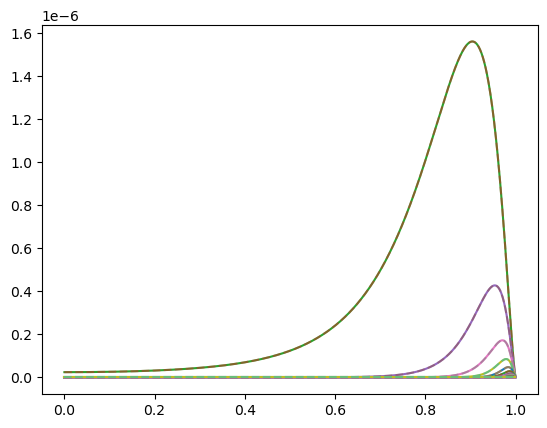

In [5]:
#comparacion integrandos
umin = np.linspace(0,1,1000)
X = np.linspace(0,1,20)
for x in X:
    plt.plot(umin,integrand_jax(umin, x, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
    plt.plot(umin, event_rate_data.integrand(x,umin),'--',alpha=0.5)

In [8]:
str(m)

'1e-07 solMass'

In [25]:
# Convertís tus cantidades antes:
# m_val = m.to('kg').value

t_hat = np.logspace(-3, 2, 50)*u.hour.to('s')

rs_MW_val = rs_MW.to('m').value
rho_c_MW_val = rho_c_MW.to('kg/m^3').value

rs_M31_val = rs_M31.to('m').value
rho_c_M31_val = rho_c_M31.to('kg/m^3').value

D_val = D.to('m').value

l_val = l
b_val = b
uT_val = uT
# Definís la función con los parámetros fijos
d2gamadt2_MW = {str(m):[] for m in masses}
d2gamadt2_M31 = {str(m):[] for m in masses}
for m in masses: 
    m_val = m.to('kg').value

    for t_val in tqdm(t_hat):
        f_jax_MW = lambda u, x: integrand_jax(u, x, D=D_val, rs=rs_MW_val, rho_c=rho_c_MW_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        # Definís la función con los parámetros fijos
        f_jax_M31 = lambda u, x: integrand_jax(u, x, D=D_val, rs=rs_M31_val, rho_c=rho_c_M31_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        resultado_MW = double_integral_2d_jit(f_jax_MW, (0.0, uT-1e-15), (0.0, 1.0))
        resultado_M31 = double_integral_2d_jit(f_jax_M31, (0.0, uT-1e-15), (0.0, 1.0))
        
        d2gamadt2_MW[str(m)].append(resultado_MW)
        d2gamadt2_M31[str(m)].append(resultado_M31)


100%|███████████████████████████████████████████| 50/50 [00:29<00:00,  1.67it/s]


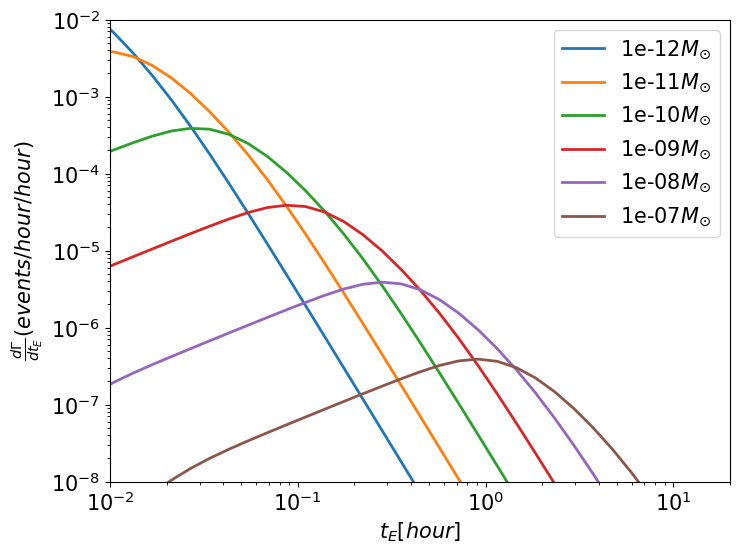

In [32]:
#niikura plots

plt.figure(figsize=(8,6))
for m in masses: 
    plt.plot(t_hat/3600,(np.array(d2gamadt2_MW[str(m)])+np.array(d2gamadt2_M31[str(m)])),lw=2, ls='-',label=str(m.value)+r'$M_{\odot}$')
# plt.plot(t_hat/3600,np.array(d2gamadt2_MW[str(m)]), alpha=0.5,lw=2, ls='--',color='b')
# plt.plot(t_hat/3600,np.array(d2gamadt2_M31[str(m)]), alpha=0.5,lw=2, ls='--',color='g')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8,1e-2)
plt.xlim(1e-2,2e1)

plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
plt.xlabel(r'$t_E [hour]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best' ,fontsize=15)
plt.savefig('/home/anibal-pc/figures_final_makler/rates_niikura.png')
plt.show()